In [1]:
import numpy as np
from scipy import stats

y1 = np.array([0.24, 0.16, 0.32, 0.54, 0.66, 0.76, 0.41])
y1A = np.array([0.24, 0.16, 0.32])
y1B = np.array([0.54, 0.66, 0.76, 0.41])
y2 = np.array([0.36, 0.48, 0.72, 0.11, 0.39, 0.28, 0.53])
y2A = np.array([0.36, 0.48, 0.72])
y2B = np.array([0.11, 0.39, 0.28, 0.53])

point = [0.38, 0.52]

mean = [y1.mean(),y2.mean()]
cov = np.cov(np.array([y1, y2]))
multnorm = stats.multivariate_normal(mean, cov)
print(mean)
print(cov)
print(multnorm.pdf(point))

mean = [y1A.mean(),y2A.mean()]
cov = np.cov(np.array([y1A, y2A]))
multnorm = stats.multivariate_normal(mean, cov)
print(mean)
print(cov)
print(multnorm.pdf(point))

mean = [y1B.mean(),y2B.mean()]
cov = np.cov(np.array([y1B, y2B]))
multnorm = stats.multivariate_normal(mean, cov)
print(mean)
print(cov)
print(multnorm.pdf(point))

[0.4414285714285714, 0.41000000000000003]
[[ 0.04908095 -0.02106667]
 [-0.02106667  0.03753333]]
3.6224715484985666
[0.24, 0.52]
[[0.0064 0.0096]
 [0.0096 0.0336]]
0.9847047567047768
[0.5925, 0.3275]
[[ 0.02289167 -0.00975833]
 [-0.00975833  0.03149167]]
1.9623691378628594


kNN accuracies: 0.84 +- 0.07 
 [0.94, 0.81, 0.87, 0.94, 0.74, 0.87, 0.84, 0.84, 0.77, 0.77]
NB accuracies: 0.82 +- 0.05 
 [0.84, 0.87, 0.84, 0.87, 0.77, 0.84, 0.9, 0.81, 0.77, 0.71]


/home/nunogoncalves/Desktop/Apre/apre-project/myenv/lib64/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nunogoncalves/Desktop/Apre/apre-project/myenv/lib64/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nunogoncalves/Desktop/Apre/apre-project/myenv/lib64/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


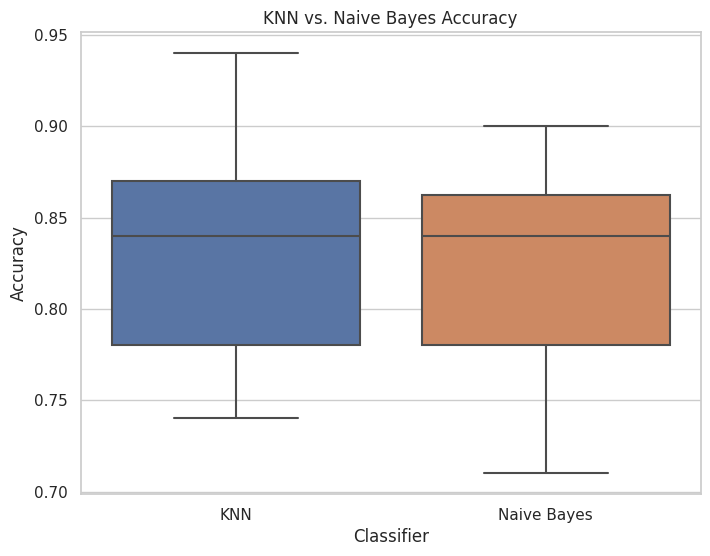

In [2]:
import pandas as pd
from scipy.io.arff import loadarff
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns

data = loadarff('column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')
X = df.drop('class', axis=1)
y = df['class']

folds = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

knn_predictor = KNeighborsClassifier(n_neighbors=5)
nb_predictor = GaussianNB()
knn_accs, nb_accs = [], []

for train_k, test_k in folds.split(X, y):
    X_train, X_test = X.iloc[train_k], X.iloc[test_k]
    y_train, y_test = y.iloc[train_k], y.iloc[test_k]

    knn_predictor.fit(X_train, y_train)
    nb_predictor.fit(X_train, y_train)
    knn_pred, nb_pred = knn_predictor.predict(X_test), nb_predictor.predict(X_test)

    knn_accs.append(round(metrics.accuracy_score(y_test, knn_pred), 2))
    nb_accs.append(round(metrics.accuracy_score(y_test, nb_pred), 2))

print("kNN accuracies:", round(np.mean(knn_accs), 2), "+-", round(np.std(knn_accs), 2), "\n", knn_accs)
print("NB accuracies:", round(np.mean(nb_accs), 2), "+-", round(np.std(nb_accs), 2), "\n", nb_accs)

boxplot_data = {'Classifier': ['KNN'] * len(knn_accs) + ['Naive Bayes'] * len(nb_accs),
        'Accuracy': knn_accs + nb_accs}

boxplot_df = pd.DataFrame(boxplot_data)
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.boxplot(x='Classifier', y='Accuracy', data=boxplot_df)
plt.title('KNN vs. Naive Bayes Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.show()

In [3]:
stats.ttest_rel(knn_accs, nb_accs, alternative='greater')

TtestResult(statistic=0.9923982173934255, pvalue=0.1734666237861796, df=9)

H0 - KNN avg = NB avg <br>
H1 - KNN avg > NB avg

p-value ~= 0.17, pelo que não podemos rejeitar H0 para os valores de referência (alpha <= 0.1), desfavorecendo
assim a hipótse enunciada (H1).

                  Predicted Hernia Predicted Normal Predicted Spondylolisthesis
Hernia                          -2                2                           0
Normal                          -5                2                           3
Spondylolisthesis                0                1                          -1


Text(0.5, 48.749999999999986, '')

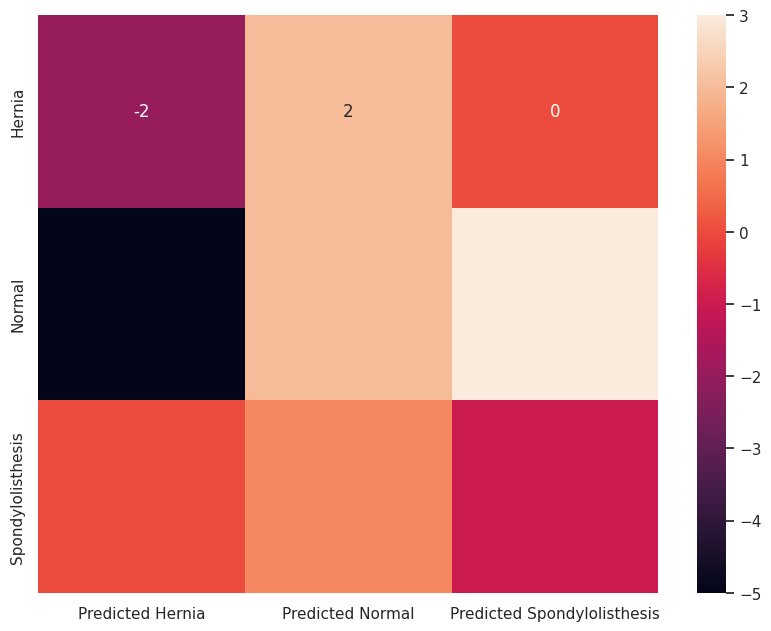

In [4]:
from sklearn.metrics import confusion_matrix
from functools import reduce

knn_predictor_1 = KNeighborsClassifier(n_neighbors=1, weights='uniform', p=2)
knn_predictor_5 = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)

cm_1_list = []
cm_5_list = []

for train_k, test_k in folds.split(X, y):
    X_train, X_test = X.iloc[train_k], X.iloc[test_k]
    y_train, y_test = y.iloc[train_k], y.iloc[test_k]

    knn_predictor_1.fit(X_train, y_train)
    knn_predictor_5.fit(X_train, y_train)
    knn_1_pred, knn_5_pred = knn_predictor_1.predict(X_test), knn_predictor_5.predict(X_test)

    cm_1 = np.array(confusion_matrix(y_test, knn_1_pred, labels=sorted(y.unique())))
    cm_1 = pd.DataFrame(cm_1, index=sorted(y.unique()), columns=[list(map(lambda x: "Predicted " + x, sorted(y.unique())))])
    cm_1_list.append(cm_1)

    cm_5 = np.array(confusion_matrix(y_test, knn_5_pred, labels=sorted(y.unique())))
    cm_5 = pd.DataFrame(cm_5, index=sorted(y.unique()), columns=[list(map(lambda x: "Predicted " + x, sorted(y.unique())))])
    cm_5_list.append(cm_5)

cm_1_acc = reduce(lambda x, y: x + y, cm_1_list)
cm_5_acc = reduce(lambda x, y: x + y, cm_5_list)

cm_diff = cm_1_acc - cm_5_acc
pd.set_option('display.expand_frame_repr', False)
print(cm_diff)
plt.figure(figsize=(10, 7.5))
sns.heatmap(cm_diff, annot=True, fmt='d')
plt.xlabel("")

Calculámos a diferença entre a matriz de confusão cumulativa de k = 1 e k = 5, pelo que um resultado positivo indica que essa célula tem um valor maior para k = 1 do que 5 e o contrário para resultados negativos.

O modelo k = 1 tem tendência a classificar mais casos como Normal, enquanto que o modelo k = 5 tem uma maior predisposição para classificar como Hernia. Quanto a classificações como Spondylolisthesis, ambos os modelos têm um comportamento semelhante.

Relativamente às maiores diferenças entre estes modelos, podemos observar que o modelo k = 5 classificou incorretamente mais 5 casos "Normal" como "Hernia" e menos 3 casos "Normal" como "Spondylolisthesis".

Possibilities in favor of kNN, i.e. against NB were also considered when grading, including: 1) variable
dependencies (inadequacy of independence assumption); 2) variables not normally distributed (inadequacy
of Gaussian assumption); 3) probability estimates from a limited number of observations (e.g., inadequate
estimates, null probabilities); 4) imbalanced class creating biases in MAP estimates via priors; ...